# Exploring census blocks & joining to 911 data
911 calls file is [here](https://app.box.com/file/911911135646), and was provided manually by Jimmy McBroom, a data engineer for the city. In theory, you should be able to get it from [the open data portal](https://data.detroitmi.gov/datasets/911-calls-for-service/explore)

2010 census blocks can be downloaded [from the census bureau](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=Blocks) or from [box](https://bloombergdotorg.box.com/s/pzaf2y8u6xmw1rgg8tr4hf7270y3q0rj). This is what detroit uses. It's in Wayne county, so that's all you need to download (its county code is 163).  
Wayne county shares a northern and largely an eastern border with Detroit, and extends further south and west

## General Census block notes
These are hierarchical, and pretty granular in populated areas.

The hierarchy looks like this, where each X is and integer: 
XX|XXX|XXXXXX|XXXX

To avoid counting Xs, the lengths are: 
2|3|6|4

With meanings: 
State | county | tract | block

## 911 calls and census blocks
The block is given by the column block_id with len(block_id)==15

The calls dataset does have null block ids (~3% in the small sample I checked). For each of them, it does have a lat/long, so we can probably figure it out

## Census block shp files
Block is given by the column GEOID10. Very well behaved

## Join notes
In the small sample I tested, the strong majority of these join correctly. like 3% do not due to mising a block ID, and < 1% are in adjacent counties (which we could pull in if we really wanted to)


## Other data with census blocks
Tons of datasets by block through the census [here](https://data.census.gov/cedsci/table?q=United%20States&g=0500000US26163%241000000)
This includes 
* population in occupied units by block. (search `DECENNIALSF12010.H10_data_with_overlays_2022-01-28T162836`)
* Population in various types of households (`DECENNIALSF12010.P30_data_with_overlays_2022-01-28T162836`)


In [63]:
import geopandas as gpd
from util_detroit import kml_to_gpd, csv_with_x_y_to_gpd

# Only read in the columns we want
COLS_911 = [
    "calldescription",
    "call_timestamp",
    "block_id",
    "category",
    "officerinitiated",
    "priority",
    "oid",
    "longitude",
    "latitude"
]

In [64]:
call_sample_size = 100000
call = (
    csv_with_x_y_to_gpd(
        "calls_for_service_from_jimmy.csv",
        crs = 'epsg:4327',
        read_csv_args={"nrows": call_sample_size, "usecols": COLS_911 + ["longitude", "latitude"]},
    )
    #     want to use ints, but default type does not handle nulls. May factorize later
    .astype({"call_timestamp": "datetime64", "block_id": pd.Int64Dtype()}).loc[
        :, COLS_911 + ["geometry"]
    ]
)

census = (
    gpd.read_file(
        "/Users/ahakso/Downloads/wayne_county_census_blocks/tl_2010_26163_tabblock10.shp"
    )
    #     full block id is concatenation of geoid and name. Remove optional `.` delimiter
    .rename(columns={"GEOID10": "block_id"})
    #     Can't go to Int64Dtype from string, convert to int first
    .astype({"block_id": int})
    #     Use type consistent with that used for 911 calls
    .astype({"block_id": pd.Int64Dtype()})
).to_crs("EPSG:4327").loc[:,['block_id','geometry']]

display(census.head(2))
call.head(2)

,block_id,geometry
0,261635032003010,"POLYGON ((-83.00482 42.44610, -83.00500 42.446..."
1,261635032002007,"POLYGON ((-83.00380 42.44354, -83.00503 42.443..."


,calldescription,call_timestamp,block_id,category,officerinitiated,priority,oid,longitude,latitude,geometry
0,TRAFFIC STOP,2020-06-25 14:40:55,261635318001003,TRF STOP,Yes,2,3079296,-83.113801,42.387110,POINT (-83.11380 42.38711)
1,START OF SHIFT INFORMATION,2020-06-25 14:41:21,261635339003014,STRTSHFT,Yes,3,3079297,-83.081518,42.367313,POINT (-83.08152 42.36731)


In [65]:
null_count = call.block_id.isna().sum()
print(f"proportion of call block ids not present in wayne county census block data: {((~call.block_id.isin(census.block_id)).sum())/call.shape[0]:.4f}")
print(f"proportion non-null call block ids not present in wayne county census block data: {((~call.block_id.isin(census.block_id)).sum()-null_count)/(call.shape[0]-null_count):.4f}")

proportion of call block ids not present in wayne county census block data: 0.0248
proportion non-null call block ids not present in wayne county census block data: 0.0026


In [4]:
# reduce census array by dropping censuss where calls are never seen.
# census = census.loc[census.block_id.isin(call.block_id)]

# Join calls and blocks on block_id

In [41]:
id_join = pd.merge(call,census,on='block_id',how='left')
id_join.head()

,calldescription,call_timestamp,block_id,category,officerinitiated,priority,oid,geometry_x,geometry_y
0,TRAFFIC STOP,2020-06-25 14:40:55,261635318001003,TRF STOP,Yes,2,3079296,POINT (-83.11380 42.38711),"POLYGON ((-83.11010 42.38766, -83.11334 42.386..."
1,START OF SHIFT INFORMATION,2020-06-25 14:41:21,261635339003014,STRTSHFT,Yes,3,3079297,POINT (-83.08152 42.36731),"POLYGON ((-83.08151 42.36730, -83.08165 42.367..."
2,DISTURBANCE,2020-06-25 14:41:31,261635129003001,DISTURB,No,3,3079298,POINT (-82.94905 42.37831),"POLYGON ((-82.94905 42.37830, -82.95019 42.377..."
3,DISTURBANCE,2020-06-25 14:41:33,261635352003007,DISTURB,No,3,3079299,POINT (-83.17806 42.37468),"POLYGON ((-83.17805 42.37467, -83.18240 42.374..."
4,SPECIAL ATTENTION,2020-06-25 14:43:07,261635413002003,SPCL ATT,Yes,3,3079300,POINT (-83.28121 42.42880),"POLYGON ((-83.28167 42.42631, -83.28169 42.426..."


# Join calls and block where the calls x/y is in the block's polygon 
We have some context from detroit that block_id has no anonymization in it, while lat/long does. Therefore, we expect some mismatch between point/polygon and block_id/block_id


To get a better sense of how often it is happening and how far the snapping can move a data point. We won't have perfect visibility, but if they mostly match (passing the sanity test), then for each call with mismatched block_ids, we can measure the distance between the lat/long and the closest edge of the actual block id – this will give us the minimum it had to have moved in the snapping
We can then look at the distribution of those distances to get some vague sense of how far the snapping can move the point. The max will probably be the most interesting, barring the presence of massive distances which would indicate some sort of upstream error. 

In [42]:
space_join = gpd.sjoin(call.loc[:,['geometry','block_id']], census.loc[:,['block_id','geometry']], how='left', op='intersects',lsuffix='call',rsuffix='census')

In [43]:
space_join.head()

,geometry,block_id_call,index_census,block_id_census
0,POINT (-83.11380 42.38711),261635318001003,16003.0,261635318001002
1,POINT (-83.08152 42.36731),261635339003014,29464.0,261635339003014
2,POINT (-82.94905 42.37831),261635129003001,19823.0,261635129003000
3,POINT (-83.17806 42.37468),261635352003007,23109.0,261635352003007
4,POINT (-83.28121 42.42880),261635413002003,14198.0,261635418001004


In [45]:
unmatched = space_join.block_id_census.isna().sum()
in_block_but_disagreeing=(space_join.dropna(how='any').block_id_call==space_join.dropna(how='any').block_id_census).sum()
print(f"calls not inside a wayne county census block: {unmatched} ({100*unmatched/space_join.shape[0]:.1f})%")
print(f"matched blocks disagreeing: {in_block_but_disagreeing} ({100*in_block_but_disagreeing/space_join.dropna(how='any').shape[0]:.1f})%")


calls not inside a wayne county census block: 3034 (3.0)%
matched blocks disagreeing: 32212 (33.2)%


In [60]:
# west of this longitude, these point are all stacked on top of each other in a random-ass location. 
display(call.loc[lambda x: call.longitude< -84].head())
# these are all null block ids (comprising most, if not all, the missing ids)
call.loc[lambda x: call.longitude< -84].block_id.notna().sum()

,calldescription,call_timestamp,block_id,category,officerinitiated,priority,oid,longitude,latitude,geometry
55,FELONIOUS ASSAULT REPORT,2020-06-25 15:00:58,<NA>,FA RPT,Yes,4,3079351,-84.132207,42.082976,POINT (-84.13221 42.08298)
100,TOWING DETAIL,2020-06-25 15:15:56,<NA>,TOW,Yes,3,3079396,-84.132207,42.082976,POINT (-84.13221 42.08298)
114,WNTD WRRNT FELONY,2020-06-25 15:18:54,<NA>,FELONY,Yes,2,3079410,-84.132207,42.082976,POINT (-84.13221 42.08298)
162,TRAFFIC STOP,2020-06-25 15:30:52,<NA>,TRF STOP,Yes,2,3079458,-84.132207,42.082976,POINT (-84.13221 42.08298)
279,REMARKS,2020-06-25 16:02:41,<NA>,REMARKS,Yes,3,3079576,-84.132207,42.082976,POINT (-84.13221 42.08298)


0

<AxesSubplot:>

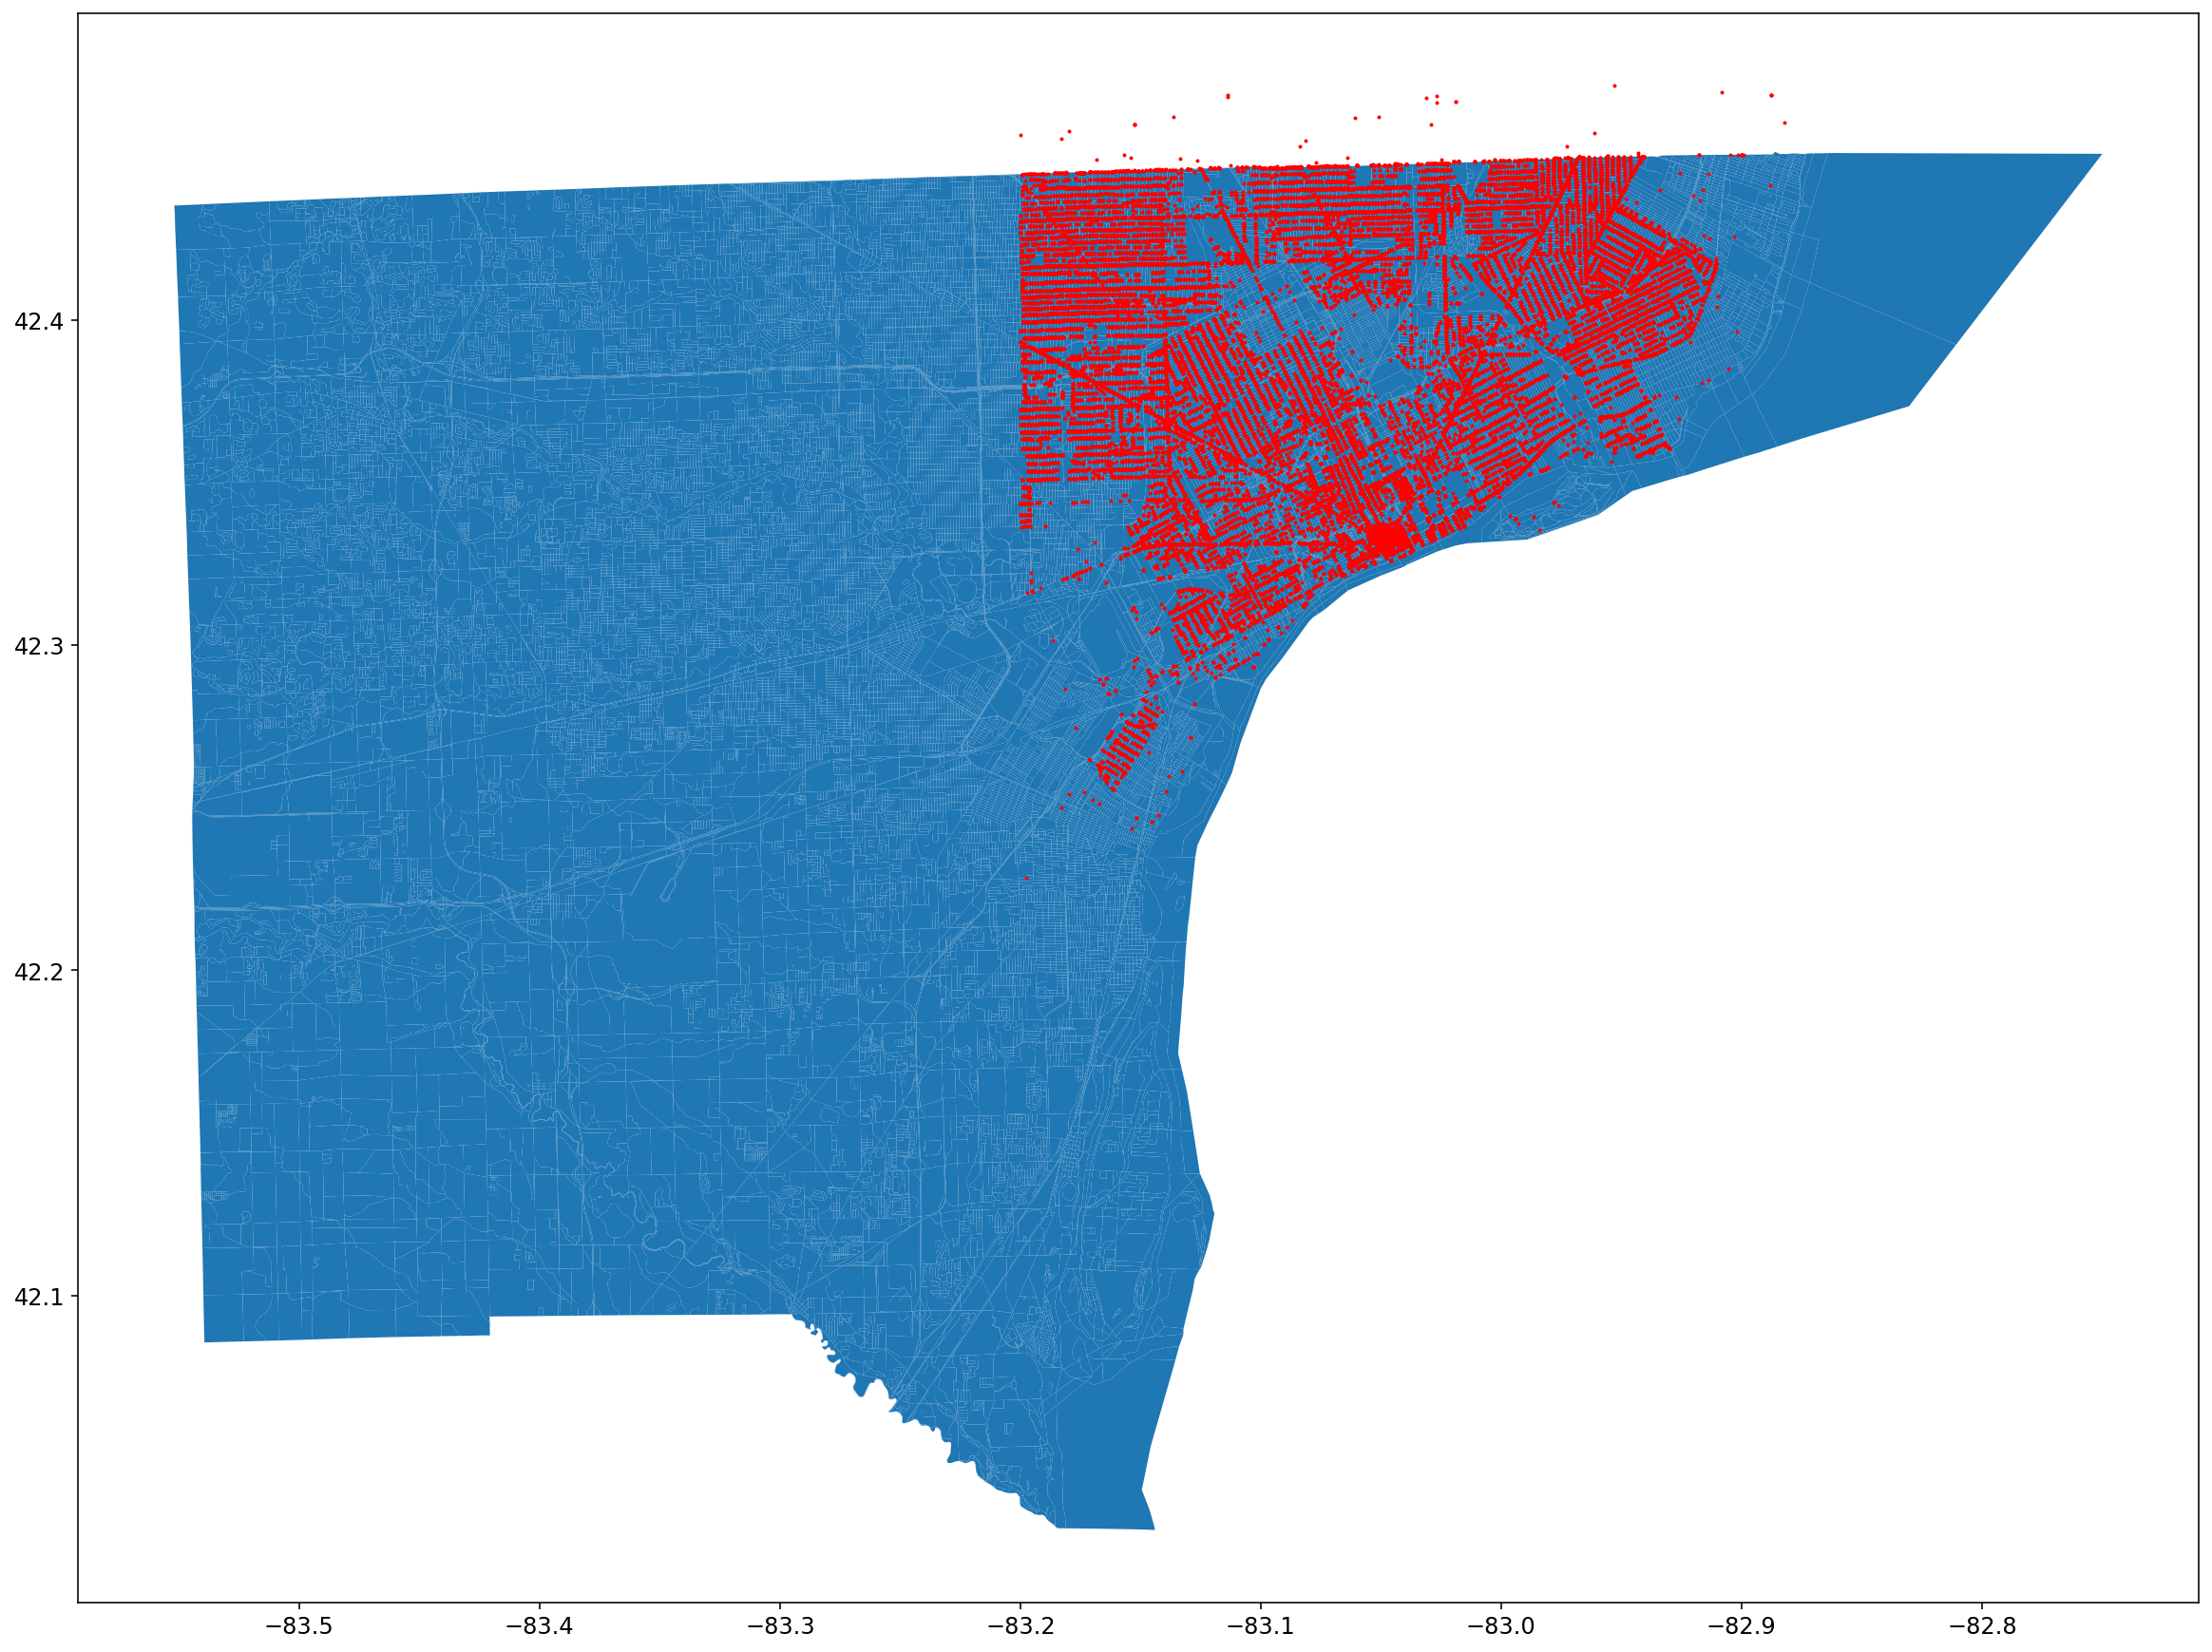

In [62]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
census.plot(ax=ax)
# exclude ~2% of call that are stacked on top of each other way outside of detroit
call.loc[lambda x: x.longitude > -83.2].plot(ax=ax,markersize=1,color='r')

# Population


In [96]:
call.dtypes

calldescription             object
call_timestamp      datetime64[ns]
block_id                     Int64
category                    object
officerinitiated            object
priority                    object
oid                          int64
longitude                  float64
latitude                   float64
geometry                  geometry
dtype: object

In [97]:
pop

block_id    object
total        int64
dtype: object

In [102]:
pd.merge(call.head(2000),pop.astype({'block_id': int}),on='block_id',).total.isna().sum()

0